In [292]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import math

# LABEL CORRECTING

In [293]:
def FIFO_label_correcting(graph, source, sink):
    labels = {node : float('inf') for node in graph.nodes()}
    labels[source] = 0
    predecessors = {}
    predecessors[source] = 0
    q = [source]

    while q:
        u = q.pop(0)
        for v in graph.successors(u):
            if labels[v] > labels[u] + graph[u][v]['cost']:
                labels[v] = labels[u] + graph[u][v]['cost']
                predecessors[v] = u
                if v not in q:
                    q.append(v)

    # traverse backward to trace the shortest path
    u = sink
    links = []
    # if predecessors does not contain sink then there doesn't exist a path from source to sink
    if sink not in predecessors: return labels, links 

    while u != source:
        links.append((predecessors[u],u))
        u = predecessors[u]
    links.reverse()
    return labels, links

In [294]:
def TDLC(graph, sink, M, step):
  labels = {node : [float('inf') for _ in range(0,(M+1)*step,step)] for node in graph.nodes}  # contain all the vectors of M labels of nodes corresponding to M interval
  labels[sink] = [0 for _ in range(0,(M+1)*step,step)]
  SElist = [sink]  # the queue to push visited nodes
  paths = {node : {t : [] for t in range(0,(M+1)*step,step)} for node in graph.nodes}  # contain shortest paths of nodes
  paths[sink] = {t : [sink] for t in range(0,(M+1)*step,step)}

  while SElist:
      v = SElist.pop(0)
      for u in graph.predecessors(v):
        changed = False
        for t in range(0,(M+1)*step,step):
            # if the time considered is out of the scope of M -> assign inf value so that the label won't be updated 
            # in other words, it is impossible to travel this node at this time
            if t + graph[u][v]['cost'][t] > M:
                newlabel = float('inf')  
            else:
                newlabel = graph[u][v]['cost'][t] + labels[v][int(t + graph[u][v]['cost'][t])]
            # update the label if the new label if better and append the path
            if labels[u][t] > newlabel: 
                labels[u][t] = newlabel
                changed = True
                paths[u][t] = [u] + paths[v][int(t + graph[u][v]['cost'][t])]
        # if the node has any update in its label vector, push it to the SE list        
        if changed:
            SElist.append(u)

  return labels, paths

# MIN COST FLOW SUCCESSIVE SHORTEST PATH

In [295]:
def mcf_ssp(graph, source, sink, target_flow):
    while True:
        # The flow to all successors of supersource is satisfied (the demand of all source is met) 
        if sum([graph[source][v]['flow'] for v in graph.successors(source)]) >= target_flow:
            break

        residual_graph = nx.DiGraph()
        for u, v, data in graph.edges(data=True):
            residual_capacity = data['capacity'] - data['flow']
            if residual_capacity > 0:  # only add the edge with remain capacity > 0 to the residual graph
                residual_graph.add_edge(u, v, capacity=residual_capacity, cost=data['cost'])

        # using label correcting to find the shortest path
        _, shortest_path = FIFO_label_correcting(residual_graph, source, sink)

        # If there is no minimum cost path, terminate the algorithm.
        if len(shortest_path) == 0:
            break
            
        # the maximum flow on the paths found is the minimum capacity of all the edges
        max_augmentable_flow = min([residual_graph[u][v]['capacity'] for u, v in shortest_path])

        # Augment the flow along the shortest path
        for u, v in shortest_path:
            graph[u][v]['flow'] += max_augmentable_flow

In [296]:
def td_mcf_ssp(graph, source, sink, M, step, target_flow):
    start = 0
    sum_flow = 0
    while True:
        # if the demand of sources is met then done
        if sum_flow >= target_flow: break

        # the case when there's no path from source to sink at any starting time
        if start > M: 
            print(f'imposible to go from {source}')
            return
        
        # initialize the capacity list and cost list for the residual graph
        residual_graph = nx.DiGraph()
        residual_capacity = {(u,v) : np.zeros(M+1,dtype = int) for u,v in graph.edges()}
        residual_cost = {(u,v): [float('inf')] * (M+1) for u, v in graph.edges()}

        for t in range(0,(M+1)*step,step):
          for u, v, data in graph.edges(data = True):
              residual_cap= data['capacity'][t] - data['flow'][t]
              if residual_cap > 0: # only add the edge if one of it capacities in capacity list is greater than zero
                  residual_graph.add_edge(u, v)
                  # call the capacity at time t as valid if it is greater than zero, the cost at time t is also valid -> included in the graph
                  # in case the capacity at time t is not valid, the cost at time t is set to inf -> prevent updating label in label correcting algorithm
                  residual_cost[u,v][t] = data['cost'][t]
                  residual_capacity[u,v][t] = residual_cap
        nx.set_edge_attributes(residual_graph, residual_cost, 'cost')

        __dict__, paths = TDLC(residual_graph, sink, M, step)

        # only take the shortest path starting with source and at specified time
        shortest_path = paths[source][start] 
        
        # If there is no minimum cost path at time t anymore, increase the starting time by 1
        if len(shortest_path) == 0:
            start += 1
            continue

        # Calculate the maximum flow that can be augmented along the shortest path.
        links = [(shortest_path[i], shortest_path[i+1]) for i in range(len(shortest_path)-1)] # segment the paths into edges
        t = start
        capacities = []
        for u,v in links:
            capacities.append(residual_capacity[u,v][t]) # take the capacity of edge travel time-dependently
            t += graph[u][v]['cost'][t]
        max_augmentable_flow = min(capacities)
        sum_flow += max_augmentable_flow

        # Augment the flow along the shortest path.
        t = start
        for u, v in links:
            graph[u][v]['flow'][t] += max_augmentable_flow
            t += graph[u][v]['cost'][t]
    

# SIMULATION

## Example of min cost flow successive shortest path

In [297]:
G = nx.DiGraph()
G.add_edge('s','1')
G.add_edge('1','2')
G.add_edge('1','3')
G.add_edge('2','3')
G.add_edge('2','4')
G.add_edge('3','4')
G.add_edge('3','5')
G.add_edge('4','t')
G.add_edge('5','t')

M = 15
arc_flow = {(u,v): np.zeros(M+1) for u,v,data in G.edges(data = True)}

arc_capacity = {(u,v): np.random.randint(1,7,M+1).tolist() for u,v,data in G.edges(data = True)}
arc_capacity['s','1'] = (np.ones(M+1)*5).tolist()
arc_capacity['4','t'] = (np.ones(M+1)*3).tolist()
arc_capacity['5','t'] = (np.ones(M+1)*2).tolist()

arc_cost = {(u,v): np.random.randint(1,4,M+1).tolist() for u,v,data in G.edges(data = True)}
arc_cost['4','t'] = list(map(int,np.zeros(M+1).tolist()))
arc_cost['5','t'] = list(map(int,np.zeros(M+1).tolist()))
arc_cost['s','1'] = list(map(int,np.zeros(M+1).tolist()))
arc_cost

nx.set_edge_attributes(G, arc_flow, 'flow')
nx.set_edge_attributes(G, arc_capacity, 'capacity')
nx.set_edge_attributes(G, arc_cost, 'cost')
td_mcf_ssp(G, 's', 't', M, 1, 5)

{('s', '1'): 5, ('1', '2'): 2, ('1', '3'): 3, ('2', '3'): 2, ('2', '4'): 0, ('3', '4'): 3, ('3', '5'): 2, ('4', 't'): 3, ('5', 't'): 2}


''

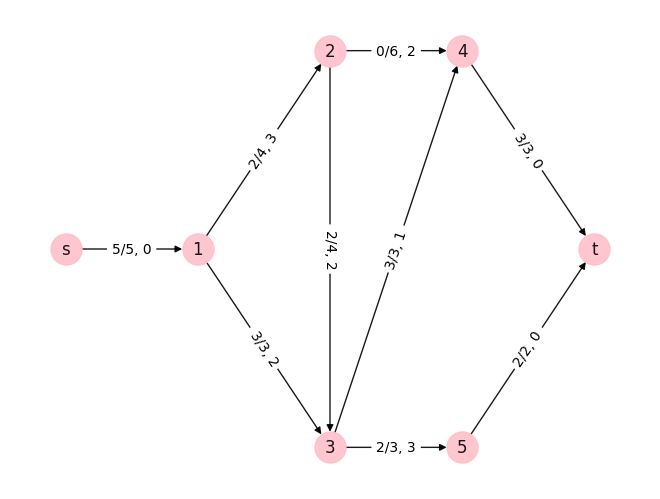

In [298]:
np.random.seed(15)
arc_capacities = {(u,v): np.random.randint(3,7) for u, v in G.edges()}
arc_capacities['s','1'] = 5
arc_capacities['4','t'] = 3
arc_capacities['5','t'] = 2
arc_costs = {(u,v): np.random.randint(1,4) for u,v in G.edges()}
arc_costs['s','1'], arc_costs['4', 't'], arc_costs['5','t'] = 0,0,0
arc_flow = {(u,v): 0 for u, v in G.edges}
nx.set_edge_attributes(G, arc_capacities, 'capacity')
nx.set_edge_attributes(G, arc_costs, 'cost')
nx.set_edge_attributes(G, arc_flow, 'flow' )
mcf_ssp(G, 's', 't', 5)
print({(u, v): data['flow'] for u,v,data in G.edges(data = True)})
pos = {
    's' : (0,0) ,
    '1' : (1,0) ,
    '2' : (2,0.5), 
    '3' : (2,-0.5),
    '4' : (3,0.5),
    '5' : (3,-0.5),
    't' : (4,0)
}
nx.draw(
    G, pos, edge_color='black', width=1, linewidths=1,
    node_size=500, node_color='pink', alpha=0.9,
    labels={node: node for node in G.nodes()}
)
nx.draw_networkx_edge_labels(G, pos,  edge_labels={(u,v) : f"{data['flow']}/{data['capacity']}, {data['cost']}" for u,v,data in G.edges(data = True)})
;

## Simulation on network of 20 nodes

''

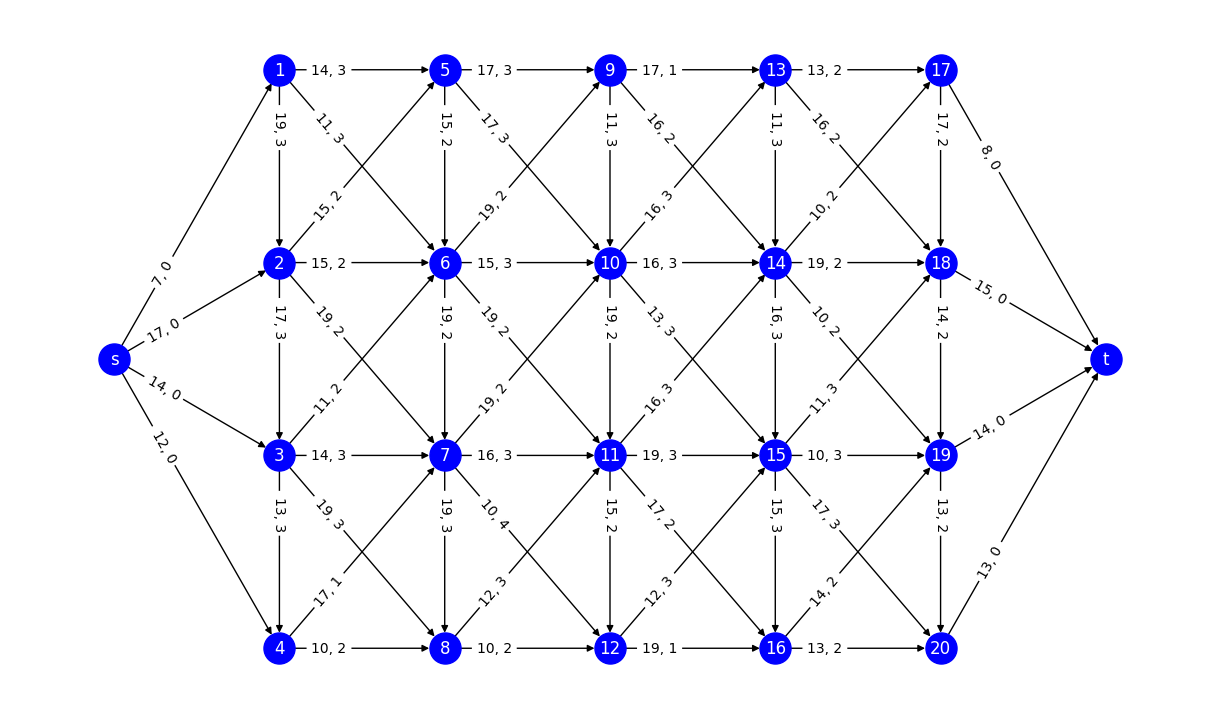

In [299]:
# initialize the network with nodes and edges, specify the position of nodes for graph
network = nx.DiGraph()
for i in range(1,21):
    network.add_node(i)
for i in range(1,21,4):
    for j in range(i,i+4):
        if not i == 17: network.add_edge(j,j+4)
        if not j % 4 == 0:
            network.add_edge(j,j+1)
            if not i == 17: network.add_edge(j,j+5)
        if not j % 4 == 1 and not i == 17:
            network.add_edge(j,j+3)
for i in range(1,5):
    network.add_edge('s',i)
for i in range(17,21):
    network.add_edge(i, 't')
pos = {}
t = 0
for i in range(1,21,4):
    for j in range(i,i+4):
        pos[j] = (t,-j % 4)
    t += 1
pos['s'] = (-1,1.5)
pos['t'] = (5,1.5)


# M: number of interval
# numcar: number of total demand
# p: the penalty coeficient of stage 1
# T: the time threshold of stage 2
# S: the number of scenarios
M = 15
num_car = 50
seed = 15
p = 5
T = 2
S = 3

np.random.seed(seed)
# generate lagrange multipliers for each edges of all the scenarios
lagrange_multiplier = [{(u,v): (np.random.random(size = T)*0.7).tolist() for u,v in network.edges()} for i in range(0,S)]

# temporary dict to hold the sum of lagrange multipliers of each edges
sum_lagrange = [{ (u,v) : sum(lagrange_multiplier[i][u,v]) for u, v in network.edges()} for i in range(0,S)]

# dict to hold the sum of lagrange multiplier of all scenarios sum_i^S(sum_t^M(alpha_ij))
sum_alphas = {(u,v) : sum([sum_lagrange[i][u,v] for i in range(0,S)]) for u,v in network.edges()}

# the generalized cost for subproblem 1 - take integer value only as the unit is min
travel_time = {(u,v) : int(p - sum_alphas[u,v]) for u,v in network.edges()}
capacities = {(u,v): np.random.randint(10,20) for u, v in network.edges()}
flows = {(u,v): 0 for u, v in network.edges()}

sources = [1,2,3,4]
sinks = [17,18,19,20]

# randomly generate the demand at sources and sinks by multinomial distribution
cap_source = np.random.multinomial(num_car, [1/4]*4) 
cap_sink = np.random.multinomial(num_car, [1/4]*4)

for i in sources:
    travel_time['s',i] = 0
    capacities['s',i] = cap_source[(i - 1) % 4]
for i in sinks:
    travel_time[i, 't'] = 0
    capacities[i, 't'] = cap_sink[(i - 1) % 4]

nx.set_edge_attributes(network,travel_time,'cost')
nx.set_edge_attributes(network,capacities, 'capacity')
nx.set_edge_attributes(network,flows, 'flow')


plt.figure(figsize = (12,7))
# drawing the nodes, and edges
nx.draw(
    network, pos, edge_color='black', width=1, linewidths=1,
    node_size=500, node_color='blue', font_color = 'white',
    labels={node: node for node in network.nodes()},
)

# labeling the edges
nx.draw_networkx_edge_labels(
    network, pos,
    edge_labels={(u,v) : f"{data['capacity']}, {data['cost']}" for u,v,data in network.edges(data = True)},
    label_pos = 0.7,
    font_color='black'
)
;

''

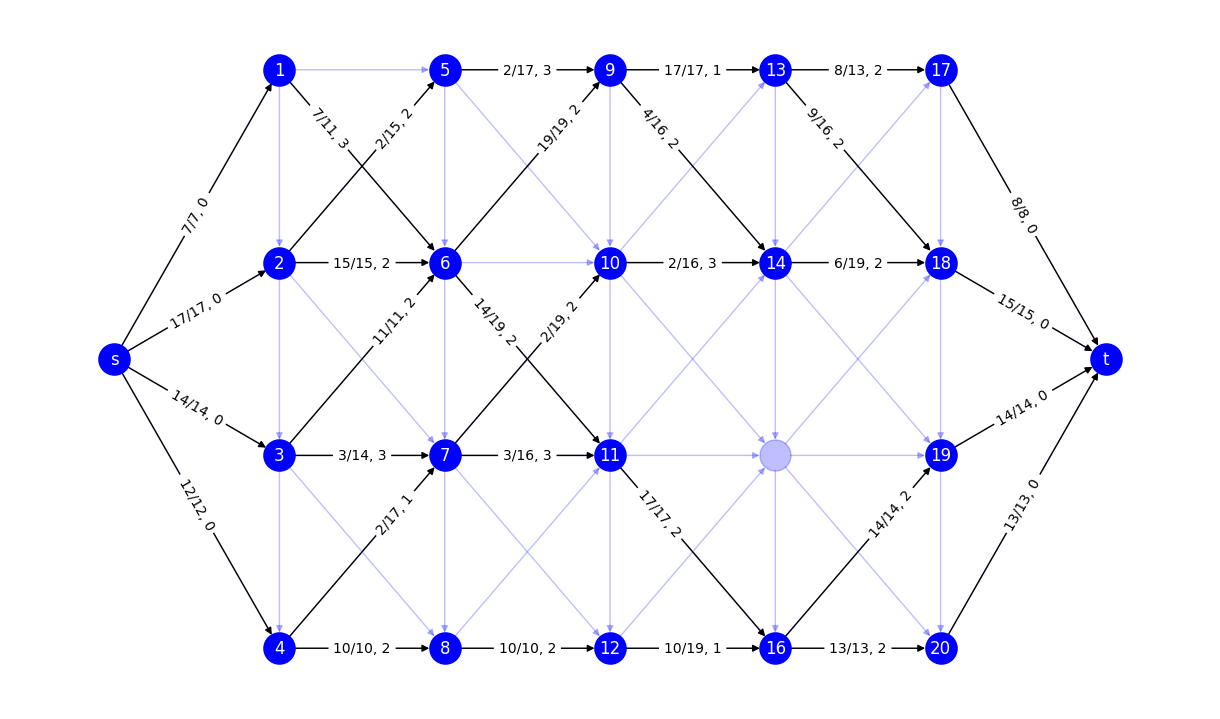

In [300]:
mcf_ssp(network, 's', 't', num_car)
# calculate the objective function of subproblem 1
SP1 = sum([data['cost'] * data['flow'] for u,v,data in network.edges(data = True)]) 
# store the cost and flow of network for later graph
x_cost = {(u,v): data['cost'] for u,v,data in network.edges(data = True)}
x_flow = {(u,v): data['flow'] for u,v,data in network.edges(data = True)}


represent = nx.DiGraph()
for u, v, data in network.edges(data = True):
    if data['flow'] > 0:
        represent.add_edge(u,v,capacity = data['capacity'], cost = data['cost'], flow = data['flow'])

plt.figure(figsize = (12,7))
# draw the network graph as underlying grid
nx.draw(
    network, pos, edge_color='blue', width=1, linewidths=1,
    node_size=500, node_color='blue', alpha = 0.25,
)

# draw the represent graph contains only the nodes and edges that visited
nx.draw(
    represent, pos, edge_color='black', width=1, linewidths=1,
    node_size=500, node_color='blue', font_color = 'white',
    labels={node: node for node in represent.nodes()},
)

# modify the labels of edges for visualization
edge_labels_center = {(u,v) : f"{data['flow']}/{data['capacity']}, {data['cost']}" for u,v,data in represent.edges(data = True) if u == 's' or v == 't' or u + 1 == v or u + 4 == v}
nx.draw_networkx_edge_labels(
    represent, pos,
    edge_labels= edge_labels_center,
    label_pos = 0.5,
    font_color='black',
)
edge_labels_right = {(u,v) : f"{data['flow']}/{data['capacity']}, {data['cost']}" for u,v,data in represent.edges(data = True) if u !=  's' and v != 't' and u + 3 == v}
nx.draw_networkx_edge_labels(
    represent, pos,
    edge_labels= edge_labels_right,
    label_pos = 0.3,
    font_color='black',
)
edge_labels_left = {(u,v) : f"{data['flow']}/{data['capacity']}, {data['cost']}" for u,v,data in represent.edges(data = True) if u !=  's' and v != 't' and u + 5 == v}
nx.draw_networkx_edge_labels(
    represent, pos,
    edge_labels= edge_labels_left,
    label_pos = 0.7,
    font_color='black',
)
;

In [301]:
np.random.seed(seed)
# generate the probability of each scenario by multinomial distribution
mu = np.random.multinomial(100, [1/S]*S)  / 100

# generate c_ij list for each edges
time_cost = [{(u,v): np.random.randint(7,13,size = M+1) for u,v in network.edges()} for _ in range(0,S)]

# update the generalized cost of edges
scenario_cost = [{(u,v) : mu[i] * time_cost[i][u,v] for u, v in network.edges()} for i in range(0,S)]
for i in range(0,S):
    for u,v in network.edges():
        for t in range(0,T):
            # add the lagrange_multipliers to cost before threshold T
            scenario_cost[i][u,v][t] += lagrange_multiplier[i][u,v][t]

# finalized the cost,capacity and flow list for each scenarios 
# assumption that at starting time 0 the capacity is the same for subproblem 1 and 2
scenario_cost = [{(u,v) : [int(scenario_cost[i][u,v][t]) for t in range(0,M+1)] for u, v in network.edges()} for i in range(0,S)]
scenario_capacities = [{(u,v): [capacities[u,v]] + np.random.randint(10,20, size = M).tolist() for u,v in network.edges()} for _ in range(0,S)]
scenario_flows = [{(u,v) : np.zeros(M+1, dtype = int).tolist() for u,v in network.edges()} for _ in range(0,S)]

# the demand of each source and sink is the same at any time t and any scenario
for i in range(0,S):
    for node in sources:
        scenario_cost[i]['s', node] = np.zeros(M+1, dtype = int).tolist()
        scenario_capacities[i]['s',node] = [capacities['s',node]] * (M+1)
    for node in sinks:
        scenario_cost[i][node,'t'] = np.zeros(M+1, dtype = int).tolist()
        scenario_capacities[i][node,'t'] = [capacities[node,'t']] * (M+1)

# calculate the objective function of subproblem 2
SP2 = 0
for i in range(0,S):
    nx.set_edge_attributes(network, scenario_cost[0], 'cost')
    nx.set_edge_attributes(network, scenario_capacities[0], 'capacity')
    nx.set_edge_attributes(network, scenario_flows[0], 'flow')
    td_mcf_ssp(network, 's', 't', M, 1, num_car)
    cost = np.array([network[u][v]['cost'] for u,v in network.edges()])
    flow = np.array([network[u][v]['flow'] for u,v in network.edges()])
    SP2 += sum(sum(cost * flow))


In [302]:
print(SP1, " ", SP2)

388   2739


''

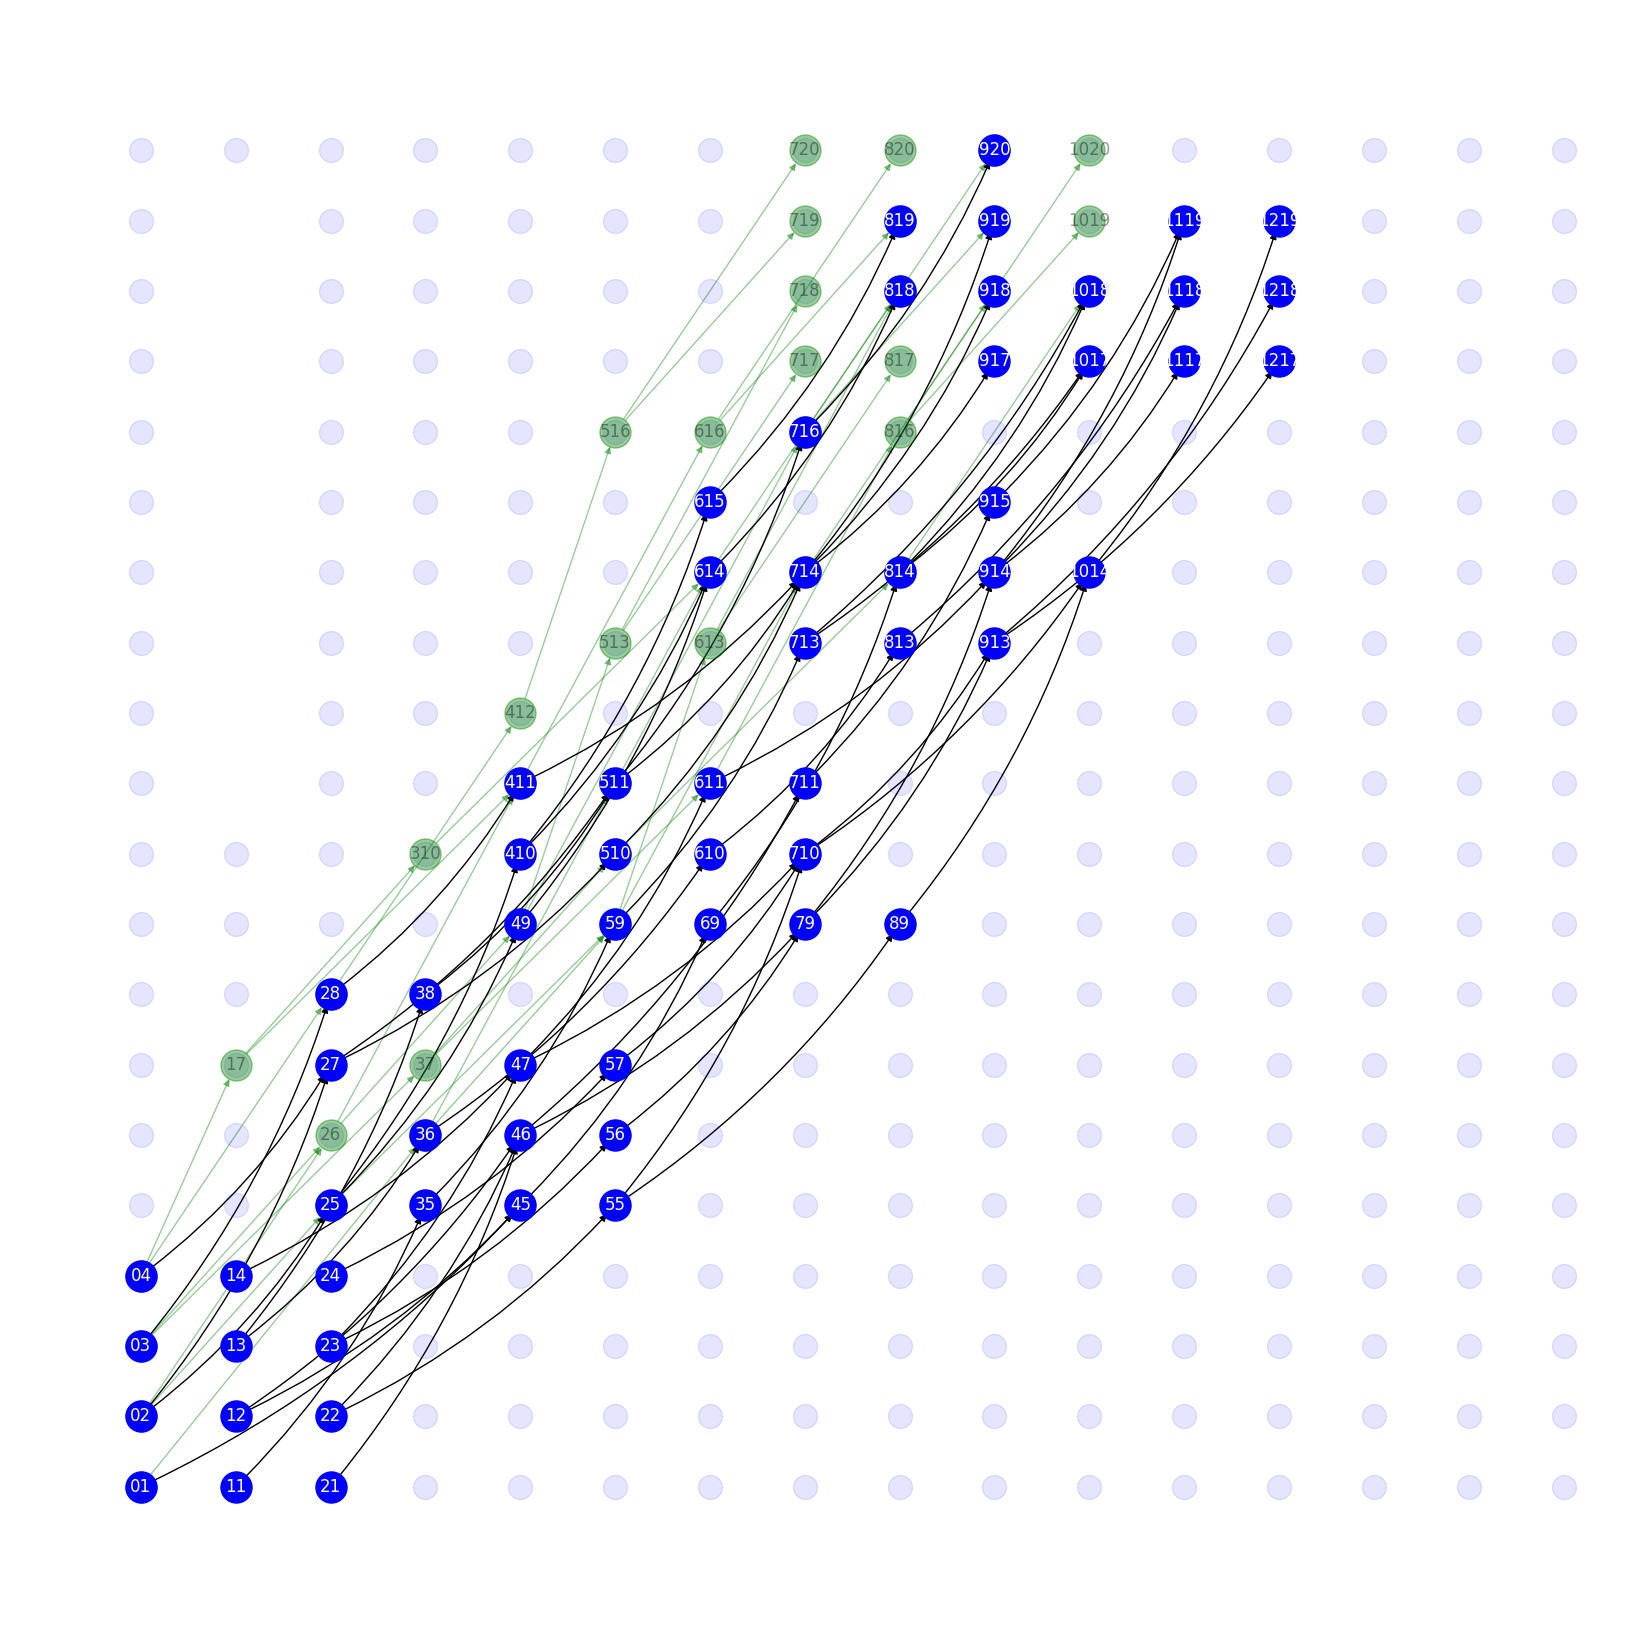

In [303]:
time_net = nx.DiGraph() # the transition over time (subproblem 2 result)
x_net = nx.DiGraph() # the transition of priori plan (subproblem 1 result)

# adding nodes and edges
pos_time = {}
for i in range(0,M+1):
    for j in range(1,21):
        time_net.add_node(str(i) + str(j))
        pos_time[str(i) + str(j)] = (i, j)

# only adding the edges with flow > 0
for t in range(0,M+1):
    for u, v, data in network.edges(data = True):
        if u == 's' or v == 't': 
            continue
        if data['flow'][t] > 0:
            time_net.add_edge(str(t)+str(u), str(data['cost'][t]+t)+str(v), capacity = data['capacity'][t], cost = data['cost'][t], flow = data['flow'][t])   

# adding the nodes and edges to priori plan
q = []
for i in sources:
    q.append((0, i))
while q:
    u = q.pop(0)
    for v in network.successors(u[1]):
        if v == 't': continue
        if x_flow[u[1],v] > 0:
            x_net.add_edge(str(u[0])+str(u[1]),str(x_cost[u[1],v] + u[0])+str(v))
            q.append((x_cost[u[1],v] + u[0],v))

plt.figure(figsize = (21,21))

# draw the underlying nodes for visualization
nx.draw_networkx_nodes(
    time_net,pos_time,
    node_color = 'blue', alpha = 0.1,
)

# draw the priori graph
nx.draw(
    x_net, pos_time, edge_color = 'green', width=1, linewidths=1,
    node_size=500, node_color='green', font_color = 'black', alpha = 0.4,
    labels = {node: node for node in x_net.nodes()}
)

node_list = []
for u,v in time_net.edges():
    if u not in node_list: node_list.append(u)
    if v not in node_list: node_list.append(v)

# draw the node with flows
nx.draw(
    time_net, pos_time, edge_color='black', width=1, linewidths=1,
    node_size=500, node_color='blue', font_color = 'white', nodelist = node_list, 
    edgelist = [],
    labels = {node: node for node in node_list},
)
# draw the edge with flows
nx.draw_networkx_edges(
    time_net, pos_time,
    edgelist = [edge for edge in time_net.edges()],
    width = 1, edge_color = 'black', connectionstyle = "arc3,rad=0.1"
)
# # labeling the edges
# nx.draw_networkx_edge_labels(
#     time_net, pos_time, 
#     edge_labels = {(u,v) : f"{data['flow']}/{data['capacity']}" for u,v,data in time_net.edges(data = True)},
#     label_pos = 0.5,
#     font_color = 'black',
#     horizontalalignment='center',
#     verticalalignment='center_baseline'
# )

;